In [1]:
from transformers import Wav2Vec2FeatureExtractor
from transformers import AutoModel
import torch
import torchaudio.transforms as T
import datasets_dcase
from scipy.io.wavfile import read as loadwav

In [2]:
train_file_list = datasets_dcase.get_dataset_filelist()
audio_file = train_file_list[0]
filename = audio_file['file_path']
class_id = audio_file['class_id']
sampling_rate, audio = loadwav(filename)
audio = audio / 32768.0
print(sampling_rate)
print(audio.shape)

22050
(88200,)


In [3]:
# loading our model weights
model = AutoModel.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)
# loading the corresponding preprocessor config
processor = Wav2Vec2FeatureExtractor.from_pretrained("m-a-p/MERT-v1-330M", trust_remote_code=True)

resample_rate = processor.sampling_rate
# make sure the sample_rate aligned
if resample_rate != sampling_rate:
    print(f'setting rate from {sampling_rate} to {resample_rate}')
    resampler = T.Resample(sampling_rate, resample_rate)
else:
    resampler = None

# audio file is decoded on the fly
if resampler is None:
    input_audio = audio
else:
    input_audio = resampler(torch.from_numpy(audio).float())

inputs = processor(input_audio.float(), sampling_rate=resample_rate, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


setting rate from 22050 to 24000


In [4]:
all_layer_hidden_states = torch.stack(outputs.hidden_states).squeeze()
print(all_layer_hidden_states.shape) # [25 layer, Time steps, 1024 feature_dim]

torch.Size([25, 299, 1024])


In [5]:
from matplotlib import pyplot as plt

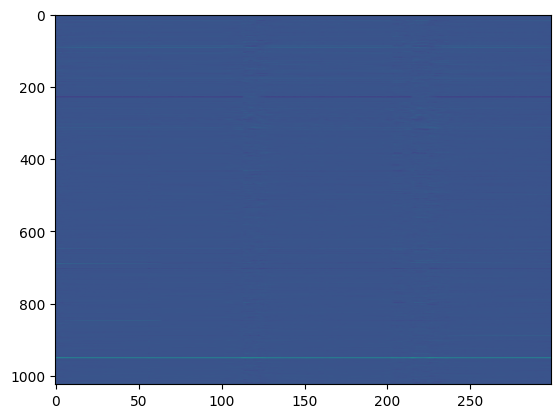

In [6]:
avg = all_layer_hidden_states.mean(0)
plt.imshow(avg.T, aspect='auto')
plt.show()